aaaa
[] []


TypeError: only integer scalar arrays can be converted to a scalar index

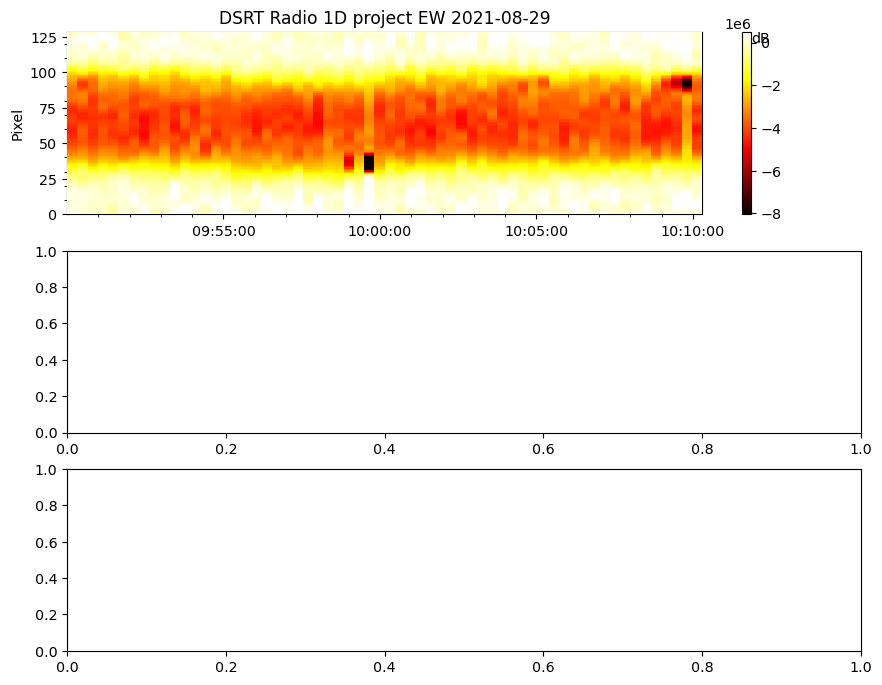

In [22]:
from scipy.interpolate import interp1d
import random
import matplotlib.dates as mdates
from astropy.io import fits
from threading import Thread
from pylab import *
import datetime
import matplotlib.ticker as ticker
def genQuicklook(prodata,spedata,start_times=None, end_times=None):

    # 设置零点
    dtime0 = datetime.datetime.strptime("00:00:00", "%H:%M:%S")
    start_time = None
    end_time = None

    # 时间转换，由字符串转换为毫秒数
    if (start_times != None):
        start_time = datetime.datetime.strptime(start_times, "%H:%M:%S")
        start_time = int(format((start_time - dtime0).seconds)) * 1000

    if (end_times != None):
        end_time = datetime.datetime.strptime(end_times, "%H:%M:%S")
        end_time = int(format((end_time - dtime0).seconds)) * 1000

    hdu = prodata

    # 未赋值或超出范围的设为边界值
    # 为不合法数据设置默认值
    if (start_time == None or start_time > hdu[1].data['time'][-1] or start_time < hdu[1].data['time'][0]):
        start_time = hdu[1].data['time'][0]
    if (end_time == None or end_time > hdu[1].data['time'][-1] or end_time < hdu[1].data['time'][0]):
        end_time = hdu[1].data['time'][-1]

    # 读出概图的成像数据
    # 1
    dataRL1 = hdu[0].data
    timeData1 = hdu[1].data['time']


    # 裁减坐标

    index1 = np.where(timeData1 >= start_time)[0][0]
    index2 = np.where(timeData1 >= end_time)[0][0]

    # 根据时间分辨率生成切割步长（成像概图数据 1秒 1格）

    time_interval = 20


    # 裁切投影图
    dataRL1 = dataRL1[:, index1:index2 + 1:time_interval]

    # 数据取反 测试
    dataRL1 = -dataRL1

    timeData1 = timeData1[index1:index2 + 1:time_interval]

    # 读入日期,设置时间起点
    datess = hdu[0].header['DATE-OBS']
    dtime0 = datetime.datetime.strptime("00:00:00", "%H:%M:%S")

    fig, axs = plt.subplots(3, 1, figsize=(10.0, 8.0), dpi=102.4)

    # ####################################################
    ax1 = axs[0]
    # 设置坐标
    # 设置时间轴范围
    trang1 = dtime0 + datetime.timedelta(seconds=timeData1[0] / 1000)
    trang2 = dtime0 + datetime.timedelta(seconds=timeData1[-1] / 1000)
    ax1.set_ylabel('Pixel')
    ax1.set_title("DSRT Radio 1D project EW" + ' ' + datess)
    ax1.set_xlim([trang1, trang2])
    ax1.set_ylim([0, dataRL1.shape[0]])
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax1.xaxis.set_minor_locator(mdates.MinuteLocator())
    ax1.yaxis.set_minor_locator(MultipleLocator(10))
    # ax1.yaxis.set_minor_locator(MultipleLocator(10))

    ax1in1 = ax1.inset_axes([0.0, 0.0, 1, 1])
    # 使用minmax归一化
    psm1 = ax1in1.pcolormesh(dataRL1, vmin=np.min(dataRL1) * 0.5, cmap='hot', vmax=np.max(dataRL1) * 0.5,
                             rasterized=True)
    ax1in1.axis('off')
    # color bar

    minv = 4.0
    maxv = 8.0
    bar1 = fig.colorbar(psm1, ax=ax1)
    bar1.ax.text(1, maxv + (maxv - minv) / 100, 'dB')

# 添加频谱概图

# 读出概图的成像数据
    spehdu = spedata
    # 1
    dataRL1 = spehdu[0].data[0]
    timeData = spehdu[1].data['time'][0]

    # 2
    dataRL2 = spehdu[0].data[1]
    freData = spehdu[1].data['frequency'][0]


    # 根据时间范围和时间间隔对图像矩阵和时间表切片


    index1 = np.where(timeData >= start_time)[0][0]
    index2 = np.where(timeData >= end_time)[0][0]


    dataRL1 = dataRL1[:, index1:index2 + 1:time_interval]
    dataRL2 = dataRL2[:, index1:index2 + 1:time_interval]

    timeData = timeData[index1:index2 + 1:time_interval]

    # 读入日期,设置时间起点
    dtime0 = datetime.datetime.strptime("00:00:00", "%H:%M:%S")

    # ####################################################
    ax1 = axs[1]
    # 设置坐标
    # 设置时间轴范围
    trang1 = dtime0 + datetime.timedelta(seconds=timeData[0])
    trang2 = dtime0 + datetime.timedelta(seconds=timeData[-1])
    ax1.set_ylabel('Frequency(MHz)')
    ax1.set_title("Spectrum Sketch HH")
    ax1.set_xlim([trang1, trang2])
    ax1.set_ylim([freData[0], freData[-1]])
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax1.xaxis.set_minor_locator(mdates.MinuteLocator(interval=5))
    # ax1.yaxis.set_minor_locator(MultipleLocator(10))

    ax1in1 = ax1.inset_axes([0.0, 0.0, 1, 1])
    psm1 = ax1in1.pcolormesh(dataRL1, vmin=np.min(
        dataRL1), cmap='gray', vmax=np.max(dataRL1), rasterized=True)
    ax1in1.axis('off')
    # #####################################################
    ax2 = axs[2]
    # 设置坐标
    # 设置时间轴范围
    trang1 = dtime0 + datetime.timedelta(seconds=timeData[0])
    trang2 = dtime0 + datetime.timedelta(seconds=timeData[-1])
    ax2.set_xlabel("Time (UT)")
    ax2.set_ylabel('Frequency(MHz)')
    ax2.set_title("Spectrum Sketch VV")
    ax2.set_xlim([trang1, trang2])
    ax2.set_ylim([freData[0], freData[-1]])
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax2.xaxis.set_minor_locator(mdates.MinuteLocator(interval=5))
    # ax1.yaxis.set_minor_locator(MultipleLocator(10))

    ax1in2 = ax2.inset_axes([0.0, 0.0, 1, 1])
    psm2 = ax1in2.pcolormesh(dataRL2, vmin=np.min(
        dataRL2), cmap='gray', vmax=np.max(dataRL2), rasterized=True)
    ax1in2.axis('off')

    return fig

if __name__=='__main__':
    print('aaaa')
    hdu1 = fits.open(r'/home/gytide/dsrtprod/data/2023/03/project_image/PRO20230301.fits')
    hdu2 = fits.open(r'/home/gytide/dsrtprod/data/2023/03/speview/SPE20210829.fits')
    fig =  genQuicklook(hdu1,hdu2)
    # print(fig)

